In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("drive/My Drive/RNA_Velocity")

Mounted at /content/drive


In [2]:
!pip install git+https://github.com/colomemaria/epiScanpy
!pip install velorama sklearn scanpy anndata
!pip install -U scvelo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/colomemaria/epiScanpy to /tmp/pip-req-build-njqit0cc
  Running command git clone --filter=blob:none --quiet https://github.com/colomemaria/epiScanpy /tmp/pip-req-build-njqit0cc
  Resolved https://github.com/colomemaria/epiScanpy to commit 6190edf8d5fde1fd84633bb60d5bcfb0cb0efc73
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.1/183.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.4 MB/s e

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import pandas as pd
import anndata as ad
import scvelo as scv


In [ ]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.22.4 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.13.5 pynndescent==0.5.10


# Initial AnnData Setup

In [ ]:
adata = sc.read_mtx('matrix.mtx').T###T to switch name of obs with n.var

FileNotFoundError: ignored

In [ ]:
adata

In [ ]:
###reading cell barcodes and gene names
genes=pd.read_csv('features.tsv',header=None)
barcodes=pd.read_csv('barcodes.tsv',sep='\t',header=None)

In [ ]:
genes.head(3)

In [ ]:

genes_=[]
for g in genes[0]:###clean the gene names and remove the unwanted charachters to get only the gene names
    genes_.append(g[19:][:-16])

In [ ]:
adata.var["gene_id"] = genes_###add gene ID and barodes to the andata
adata.obs["cell_id"] = barcodes[[0]].values##add cell ID

In [ ]:
adata.var

In [ ]:
adata.obs_names=adata.obs['cell_id'].values.tolist() ##to convert obs_name from numbers (index) to cell barcod
adata.var_names=adata.var['gene_id'].values.tolist() ##to convert var_name from numbers (index) to gene ID

# Data Preprocessing


In [ ]:

adata = sc.read_a
#Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20, )
##expecteded to see Malat1 it's mitochondrial gene, and other mitochondrial genes also usually it can detect ribosomal genes and actin

In [ ]:
##filter out cells that has less that 200 genes and genes that expressed in less than 3 cells

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [ ]:
adata.var['mt']=adata.var_names.str.startswith('mt-')##make new column with mitochondrial genes
adata.var

In [ ]:
adata.var.mt.value_counts() ###Mitchondrial genes 

In [ ]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.var_names_make_unique()##to remove the duplicates in var_names

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts (to many total count might be douplets)

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [ ]:
##filtering by slicing andata
adata = adata[adata.obs.n_genes_by_counts < 8500, :]
adata = adata[adata.obs.pct_counts_mt < 15, :]

# Normalization

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)##library size correction

In [ ]:
#Logarithmize the data , to avoid having zeros in our matrix
sc.pp.log1p(adata)

In [ ]:
#Identify highly-variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [ ]:
sc.pl.highly_variable_genes(adata)

In [ ]:
adata.var.highly_variable.value_counts()

Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

In [ ]:
adata.raw = adata

In [ ]:
adata = adata[:, adata.var.highly_variable]

In [ ]:
sc.pp.regress_out(adata, 'total_counts')#Regress out effects of total counts per cell 

In [ ]:
##PCA
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

# Computing the neighborhood graph

In [ ]:
sc.pp.neighbors(adata, n_neighbors=23, n_pcs=40)

In [ ]:
#Embedding the neighborhood graph
sc.tl.leiden(adata)
sc.tl.paga(adata)


In [ ]:
sc.tl.umap(adata)##use paga to imporve the conectivity between the clusters as umap encurage forming clusters which might shatter trajectories

In [ ]:
##stem cells markers ,clu is not agreat markers for stem cells
sc.pl.umap(adata, color=['Lgr5', 'Smoc2', 'Clu','Sox4'])

In [ ]:
##TA cells (trans-amplifying cell markers)
sc.pl.umap(adata, color=['Hmgn2', 'Ccna2', 'Mcm5'])

In [ ]:
sc.pl.umap(adata, color=['Cdhr2', 'Tmem37', 'Fabp2','Slc26a3'])##enterocytes markers

In [ ]:
sc.pl.umap(adata, color=['Muc2', 'Zg16', 'Atoh1','Reg4'])###goblet marker (secretory cells)

In [ ]:
sc.pl.umap(adata, color=['Insm1', 'Pax6','Reg4'])##EEC marker secretory cells markers, Reg4 is a general secretory marker which can be present in Goblet and EEC

In [ ]:
sc.pl.umap(adata, color=['Lyz1'])##it's for paneth cell markers, which not commonly present in colon cells, this result makes sense

In [ ]:
sc.pl.umap(adata,color='leiden',legend_loc='on data')

In [ ]:
##keep only epithelial cells
adata.obs['leiden']
adata_=adata[adata.obs['leiden'].isin(['5', '20', '2','3','1','12','13','18','23','21','14','19']),:]

In [ ]:
sc.pl.umap(adata_,color='leiden',legend_loc='on data')

In [ ]:
#Embedding the neighborhood graph##reclustering with leiden and resolution 0.2
sc.tl.leiden(adata_,resolution=0.2)
sc.tl.umap(adata_)
sc.pl.umap(adata_,color='leiden',legend_loc='on data')

In [ ]:
##stem cells, Clu is not great makers, Sox4 can be in both stem cells and trans-amplifying cells
sc.pl.umap(adata_, color=['Lgr5', 'Smoc2', 'Clu','Sox4','Axin2','Kcne3'])##cluster 

In [ ]:
##TA cells,, trans-amplifying cells (near stem cells)
sc.pl.umap(adata_, color=['Hmgn2', 'Ccna2', 'Mcm5','Pcna','Hmgb2'])

In [ ]:
sc.pl.umap(adata_, color=['Cdhr2', 'Tmem37', 'Fabp2','Slc26a3','Aqp8','Ndrg1'])##enterocytes, Slc26a3 is localized in the early enterocytes (enterocytes progenitors)

In [ ]:
sc.pl.umap(adata_, color=['Muc2', 'Zg16', 'Atoh1','Reg4'])###goblet marker

In [ ]:
sc.pl.umap(adata_, color=['Insm1', 'Pax6','Reg4'])##EEC marker
#Reg4 is a general secretory marker which can be present in Goblet and EEC

In [ ]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '0': 'Stem cells',
     '1': 'TA',
     '2': 'TA2',
     '3': 'EC2',
     '4': 'GC2',
     '5': 'EC',
     '6': 'GC',
     '7': 'GC2',
     '8': 'Unknown',
     '9': 'EEc'
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata_.obs['cell type'] = adata_.obs['leiden'].map(cluster2annotation).astype('category')

In [ ]:
sc.pl.umap(adata_,color='leiden',legend_loc='on data')

In [ ]:
adata_.write_h5ad('adata.h5ad')

# RNA velocity 

In [ ]:
import scvelo as scv
scv.logging.print_version()

In [ ]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization

In [ ]:
Mock = scv.read('MOCK.loom', cache=True)##it has unspliced matrix

In [ ]:
scv.utils.clean_obs_names(adata_)##you have to clean the obs.name to make the cell ID matching each other
scv.utils.clean_obs_names(Mock)

In [ ]:
merged=scv.utils.merge(adata_, Mock)##merg with the preprocessed data
merged

In [ ]:
scv.pl.proportions(merged)##20% of the RNA are unspliced

# Preprocess the Data

In [ ]:
adata=merged.copy()
adata

In [ ]:
scv.pp.filter_genes(adata, min_shared_counts=20)
scv.pp.normalize_per_cell(adata)
scv.pp.filter_genes_dispersion(adata, n_top_genes=5000)
scv.pp.log1p(adata)

In [ ]:
# first and second order moments (means and uncentered variances) computed among nearest neighbors 
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=5000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

In [ ]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=5000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

# Estimate RNA velocity

In [ ]:
##Dynamical Model to  learn the full transcriptional dynamics of splicing kinetics
scv.tl.recover_dynamics(adata)

In [ ]:
##calculate RNA velocity
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

In [ ]:
adata.write('Mock.h5ad')

In [ ]:
scv.pl.velocity_embedding_stream(adata, basis='umap',color='cell type')

In [ ]:
scv.pl.velocity_embedding(adata, arrow_length=5, arrow_size=5, dpi=120,color='cell type')

In [ ]:
scv.pl.velocity(adata, ['Muc2',  'Ndrg1', 'Lgr5'], ncols=2,color='cell type')
##Muc2 is for Goblet cells, Ndrg1 for differentiated cells enterocytes and secretory (goblet and EEC), Lgr5 for stem cells

The dynamical model recovers the latent time of the underlying cellular processes. This latent time represents the cell’s internal clock and approximates the real time experienced by cells as they differentiate, based only on its transcriptional dynamics.

In [ ]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80)


# Identifying Cluster-specific top-likelihood genes (potenial driver)

In [ ]:
scv.tl.rank_dynamical_genes(adata, groupby='cell type')
df_ = scv.get_df(adata, 'rank_dynamical_genes/names')

In [ ]:
df_.to_csv('potenial driver.csv', index=False)

In [ ]:
adata.layers['spliced']

In [ ]:
adata.layers['unspliced']

In [ ]:
df_.head(10)

In [ ]:
scv.pl.velocity(adata, ['Cpe',  'Fcgbp', 'Hells'], ncols=2,color='cell type')

# Calculate genes that have cluster-specific differential velocity expression

In [ ]:
scv.tl.rank_velocity_genes(adata, groupby='cell type', min_corr=.3)

In [ ]:
df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])
df.head()

In [ ]:
df.to_csv('cluster_differential_velocity.csv')

In [ ]:
adata.write('adata.h5ad')

# cell rank

import cellrank as cr givers importerror
##ImportError: cannot import name 'Iterable' from 'collections' (C:\Users\ahmed\miniconda3\envs\my_project\lib\collections\__init__.py)

In [ ]:
##this solve the error

import collections.abc
#cell rank needs the four following aliases to be done manually.
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping

In [ ]:
!pip install cellrank

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.6/250.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.0/220.0 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 79.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docrep: filename=docrep-0.3.2-py3-none-any.whl size=19891 sha256=a2d9b2474687456a5be7ee80b603d4726bebeb54a9c4ef80c0c19bedaeeee17f
  Stored in directory: /ro

In [ ]:
import cellrank as cr

In [ ]:
adata=sc.read_h5ad('adata.h5ad')
adata

AnnData object with n_obs × n_vars = 1171 × 1701
    obs: 'cell_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell type', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'gene_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes', 'spearmans_score', 'velocity_score'
    uns: 'cell type_colors', 'hvg', 'leiden', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'rank_dyna

the directional information comes from RNA velocity, and it use this information to compute initial & terminal states as well as fate probabilities for the dynamical process

In [ ]:
adata.obs

,cell_id,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,cell type,sample_batch,initial_size_unspliced,initial_size_spliced,initial_size,n_counts,velocity_self_transition,root_cells,end_points,velocity_pseudotime,latent_time
AAACCCAAGCGT,AAACCCAAGCGTCTGC-1,354,353,574.0,47.0,8.188153,3,EC2,CTGC-1,66,438,438.0,-626.630615,0.741522,6.678869e-08,4.054999e-03,0.515629,0.731463
AAACCCAAGTAC,AAACCCAAGTACCCTA-1,5246,5244,30166.0,1448.0,4.800106,1,TA,CCTA-1,6419,23082,23082.0,-553.377319,0.636521,1.164323e-08,5.411131e-03,0.169115,0.297885
AAACGCTAGGGC,AAACGCTAGGGCTAAC-1,5276,5275,38955.0,3382.0,8.681812,7,GC2,TAAC-1,10094,30227,30227.0,-427.527496,0.085589,1.236428e-04,7.215306e-03,0.206306,0.508196
AAACGCTTCTTG,AAACGCTTCTTGAACG-1,7891,7887,87154.0,4984.0,5.718613,1,TA,AACG-1,23830,65773,65773.0,-383.112946,0.480760,1.197734e-06,9.585226e-04,0.217750,0.299725
AAAGGATAGGAT,AAAGGATAGGATATGT-1,1408,1408,3288.0,1.0,0.030414,0,Stem cells,ATGT-1,94,2732,2732.0,-639.511353,0.161053,3.433464e-07,4.912501e-04,0.167977,0.644290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCGTCCG,TTTGATCGTCCGATCG-1,1182,1182,2904.0,11.0,0.378788,0,Stem cells,ATCG-1,87,2298,2298.0,-633.769531,0.141016,4.783419e-07,8.228250e-04,0.164097,0.643508
TTTGGAGTCTCT,TTTGGAGTCTCTCAAT-1,5416,5405,22165.0,1086.0,4.899617,9,EEc,CAAT-1,12632,17122,17122.0,-435.515900,0.059714,1.000000e+00,1.319672e-10,0.031961,0.001472
TTTGGTTGTACT,TTTGGTTGTACTGCCG-1,6180,6178,45186.0,3528.0,7.807728,2,TA2,GCCG-1,12354,34224,34224.0,-350.020203,0.544685,1.111503e-08,7.737058e-01,0.601990,0.442034
TTTGTTGCACAA,TTTGTTGCACAATGCT-1,387,387,524.0,31.0,5.916031,0,Stem cells,TGCT-1,72,375,375.0,-675.354370,0.098963,8.539159e-08,1.511081e-03,0.150725,0.407202


In [ ]:
#x=adata.obs['cell type'][(adata.obs['cell type']!='Stem cells') & (adata.obs['cell type']!='Unknown')]
#adata.obs['terminals']=x

<ipython-input-73-04b88bf38dc4>:3: DeprecationWarning: `cellrank.tl.terminal_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.terminal_states(adata, cluster_key='cell type')
/usr/local/lib/python3.9/dist-packages/cellrank/tl/_init_term_states.py:156: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = transition_matrix(


  0%|          | 0/1171 [00:00<?, ?cell/s]

  0%|          | 0/1171 [00:00<?, ?cell/s]

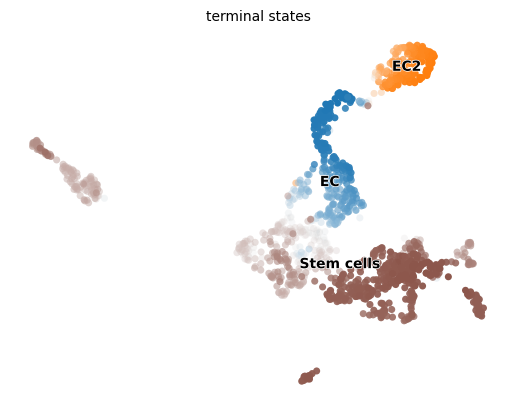

In [ ]:
#Identify terminal states
#terminals=['EC2','EEc','GC']
cr.tl.terminal_states(adata, cluster_key='cell type')

##plot the terminal state
cr.pl.terminal_states(adata)



<ipython-input-74-9760bcec602c>:2: DeprecationWarning: `cellrank.tl.initial_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.initial_states(adata, cluster_key="cell type")
/usr/local/lib/python3.9/dist-packages/cellrank/tl/_init_term_states.py:156: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = transition_matrix(


  0%|          | 0/1171 [00:00<?, ?cell/s]

  0%|          | 0/1171 [00:00<?, ?cell/s]

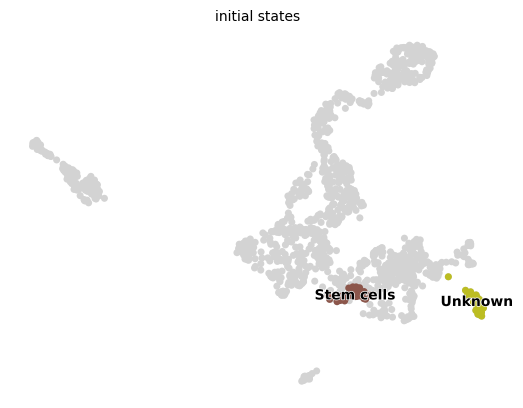

In [ ]:
#Identify initial_state 
cr.tl.initial_states(adata, cluster_key="cell type")

##plot the initial_state
cr.pl.initial_states(adata,discrete=True)

# Compute fate maps
Once we know the terminal states, we can compute associated fate maps - for each cell, we ask how likely is the cell to develop towards each of the identified terminal states.

<ipython-input-75-ebf1bcc9e093>:1: DeprecationWarning: `cellrank.tl.lineages` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.lineages(adata)##calculate cell to cell transition probabilties


  0%|          | 0/3 [00:00<?, ?/s]

/usr/local/lib/python3.9/dist-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/usr/local/lib/python3.9/dist-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/usr/local/lib/python3.9/dist-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


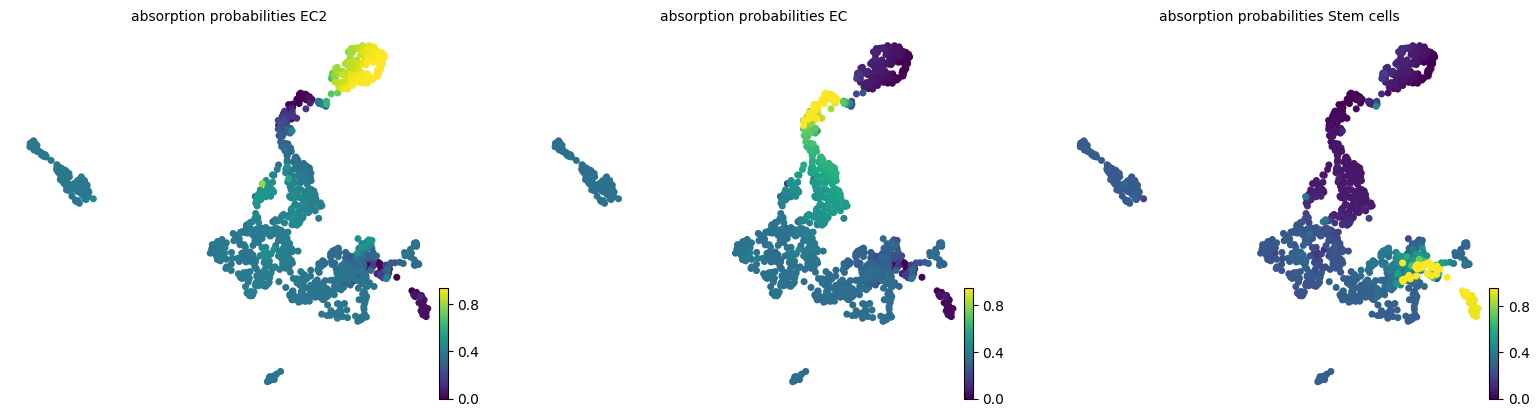

In [ ]:
cr.tl.lineages(adata)##calculate cell to cell transition probabilties
cr.pl.lineages(adata, same_plot=False)

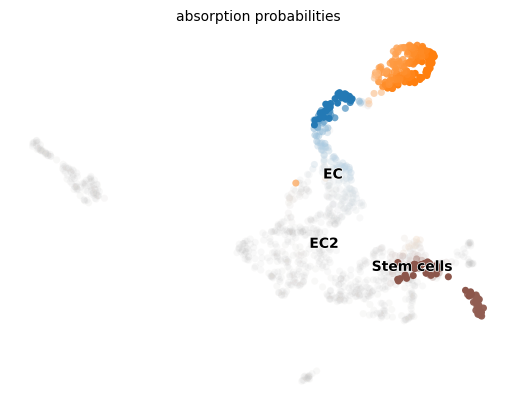

In [ ]:
cr.pl.lineages(adata, same_plot=True)

In [ ]:
adata

AnnData object with n_obs × n_vars = 1171 × 1701
    obs: 'cell_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell type', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'terminal_states', 'terminal_states_probs', 'clusters_gradients', 'initial_states', 'initial_states_probs'
    var: 'gene_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes', 'spearmans_score', 'velocity_score', 

In [ ]:
adata.obsm['to_terminal_states']

# Velorama

In [ ]:
# Re-read in adata since we can't save the cellrank data and we need to save reg and target here
adata=sc.read_h5ad('adata_for_velorama/adata.h5ad')
target_genes = pd.read_csv("potenial driver.csv")
regulator_genes = pd.read_csv("potenial_regulator.csv")

target_genes = target_genes.drop(["Unnamed: 0"], axis=1)
regulator_genes = regulator_genes.drop(["Unnamed: 0"], axis=1)

target_genes = target_genes.iloc[:10]
regulator_genes = regulator_genes["names"]


target_genes = np.unique(target_genes.to_numpy().flatten())
regulator_genes = np.unique(regulator_genes.to_numpy().flatten())

print(target_genes.shape)
print(target_genes)
print(regulator_genes.shape)
print(regulator_genes)

(82,)
['Adamts4' 'Agr2' 'Ahnak2' 'Alas2' 'Bace2' 'Bpgm' 'Capn9' 'Ccdc34' 'Ccl24'
 'Ccnb1ip1' 'Cd34' 'Cdca8' 'Cdr2' 'Cep55' 'Chek2' 'Chga' 'Cpe' 'Cyp2c68'
 'Cyp2d12' 'Ddx60' 'Depdc1a' 'Ethe1' 'Fcgbp' 'Fer1l6' 'Fkbp5' 'Foxa3'
 'Fstl1' 'Gadd45a' 'Gatm' 'Gfra3' 'Gna14' 'Gsta3' 'Guca2a' 'Hells'
 'Hepacam2' 'Hgfac' 'Hmmr' 'Iqgap3' 'Kcnmb2' 'Kif11' 'Kif15' 'Kif4' 'Klf2'
 'Klra7' 'Lad1' 'Lgals3' 'Lgr5' 'Loxl1' 'Ly6m' 'Mef2c' 'Mep1a' 'Mep1b'
 'Mgat4a' 'Muc13' 'Myh14' 'Nlrp9b' 'Nusap1' 'Pappa2' 'Plk1' 'Postn'
 'Prss30' 'Ptprn' 'Ptprr' 'Rangrf' 'Runx3' 'Sectm1b' 'Serpinb6b' 'Sez6l2'
 'Sgo2a' 'Slc1a5' 'Slc37a2' 'Snap25' 'Sval1' 'Sycn' 'Tgm3' 'Tm4sf4'
 'Tmem45b' 'Tnni1' 'Tph1' 'Tpx2' 'Tsr1' 'Ttc39a']
(1097,)
['1110038B12Rik' '1700097N02Rik' '1810026B05Rik' ... 'Zkscan1' 'Zyx'
 'Zzz3']


In [ ]:
adata.X

array([[-0.4558222 , -0.19553447, -0.36928606, ..., -0.24018934,
        -0.44599342,  0.        ],
       [-1.3929368 , -1.1231617 ,  0.        , ...,  0.7331065 ,
        -0.5221686 ,  0.        ],
       [ 0.5828814 ,  0.32113415,  0.2467825 , ..., -0.6901289 ,
        -0.54670984,  0.18331152],
       ...,
       [ 0.        ,  0.        ,  0.0774239 , ..., -0.8063227 ,
        -0.56470364, -0.1062704 ],
       [-0.4549701 , -0.19473022, -0.36770836, ..., -0.23977877,
        -0.44587234,  0.        ],
       [-0.48697442, -0.22497526, -0.42839617, ..., -0.25501347,
        -0.45032105,  0.85309213]], dtype=float32)

In [ ]:
# We need to choose a set of potential regulator genes; for now we will use ALL genes as potential regulators.
adata.var['is_reg'] = [n in regulator_genes for n in adata.var.index.values]
adata.var['is_target'] = [n in target_genes for n in adata.var.index.values]
adata.write('adata_for_velorama/adata.h5ad')

In [ ]:
print("Number of Regulators: ", sum(adata.var['is_reg']))
print("Number of Targets: ", sum(adata.var['is_target']))

Number of Regulators:  313
Number of Targets:  82


In [ ]:
# Run velorama : Performed Locally
# import scvelo as scv
# !velorama -ds adata -dyn rna_velocity -dev cuda -l 5 -hd 32 -rd adata_for_velorama

Normalizing data: 0 mean, 1 SD
# of Regs: 1701, # of Targets: 608
Constructing DAG...
Traceback (most recent call last):
  File "/usr/local/bin/velorama", line 5, in <module>
    velorama.execute_cmdline()
  File "/usr/local/lib/python3.9/dist-packages/velorama/run.py", line 93, in execute_cmdline
    A = construct_dag(adata,dynamics=args.dynamics,proba=args.proba)
  File "/usr/local/lib/python3.9/dist-packages/velorama/utils.py", line 24, in construct_dag
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
NameError: name 'scv' is not defined


# Visualizing Generated GRN

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def rank_regulator_genes(G, regulator_nodes):
    regulator_degrees = [(node, G.out_degree(node)) for node in regulator_nodes]
    regulator_degrees.sort(key=lambda x: x[1], reverse=True)
    return regulator_degrees

def find_connected_regulators(G, regulator_nodes, target_nodes):
    connected_regulators = set()
    new_connected_regulators = set()

    # Get directly connected to target regs
    for regulator in regulator_nodes:
        for target in target_nodes:
            if G.has_edge(regulator, target):
                connected_regulators.add(regulator)
                new_connected_regulators.add(regulator)

    # Get indirectly connected to target regs
    while new_connected_regulators:
        current_regulator = new_connected_regulators.pop()
        for regulator in regulator_nodes:
            if G.has_edge(regulator, current_regulator) and regulator not in connected_regulators:
                connected_regulators.add(regulator)
                new_connected_regulators.add(regulator)

    return connected_regulators

def visualize_network(gc_df, percentile, threshold=0.5):
    G = nx.DiGraph()

    for i, target_gene in enumerate(gc_df.index):
        for j, regulator_gene in enumerate(gc_df.columns):
            weight = float(gc_df.loc[target_gene, regulator_gene])
            if abs(weight) > threshold:
                G.add_edge(regulator_gene, target_gene, weight=weight)

    pos=nx.fruchterman_reingold_layout(G) # spectral, circular, spring
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}

    target_nodes = set(gc_df.index) & set(G.nodes)
    regulator_nodes = set(gc_df.columns) & set(G.nodes)
    
    connected_regulators = find_connected_regulators(G, regulator_nodes, target_nodes)

    plt.figure(figsize=(10, 10))
    nx.draw_networkx_nodes(G, pos, nodelist=target_nodes, node_color='red', node_size=100)
    nx.draw_networkx_nodes(G, pos, nodelist=connected_regulators, node_color='blue', node_size=100)
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos, font_size=10)
    
    # Add legend
    red_patch = mpatches.Patch(color='red', label='Target Genes')
    blue_patch = mpatches.Patch(color='blue', label='Regulator Genes')
    plt.legend(handles=[red_patch, blue_patch])

    plt.title("Gene regulatory network; " + str(percentile) + " percentile")
    plt.show()

    connected_regulators = find_connected_regulators(G, regulator_nodes, target_nodes)
    regulator_ranking = rank_regulator_genes(G, connected_regulators)
    print("Regulator genes ranked by the number of connections:")
    for i, (regulator, connections) in enumerate(regulator_ranking):
        print(f"{i+1}. {regulator}: {connections} connections")


In [ ]:
# Top N,M instead of threshold (not yet working)

def visualize_network_top(gc_df, percentile=95):
    list_of_weights = []
    for i, target_gene in enumerate(gc_df.index):
        for j, regulator_gene in enumerate(gc_df.columns):
            list_of_weights.append(float(gc_df.loc[target_gene, regulator_gene]))
    print("negatives: ", sum(np.array(list_of_weights) < 0))
    threshold = np.percentile(np.array(list_of_weights), percentile)
    visualize_network(gc_df, percentile, threshold)



negatives:  0


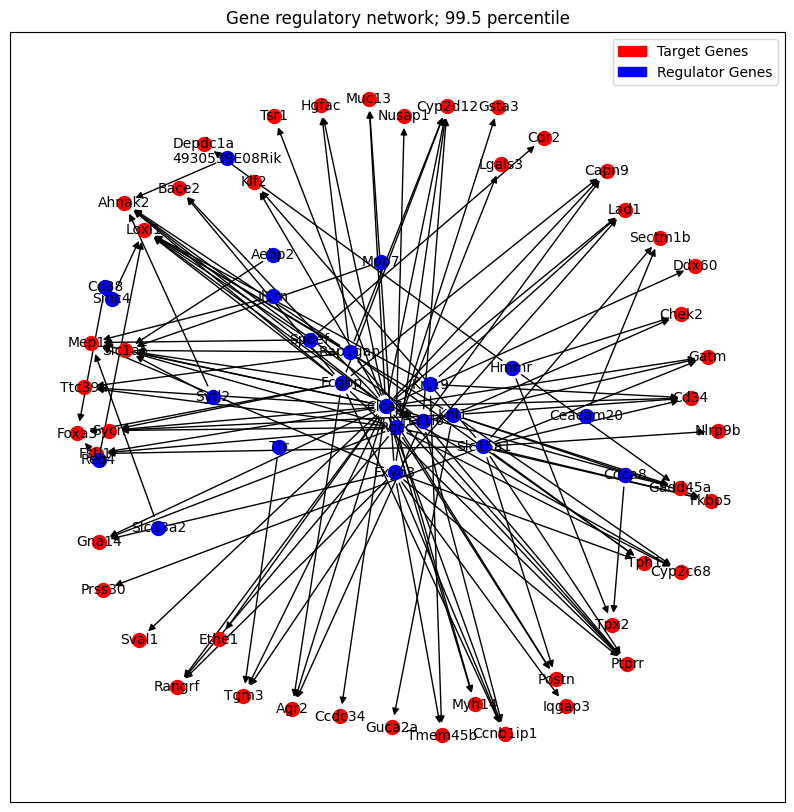

Regulator genes ranked by the number of connections:
1. Clca1: 32 connections
2. Rgcc: 14 connections
3. Fxyd3: 12 connections
4. Fcgbp: 12 connections
5. Slc15a1: 11 connections
6. Rap1gap: 8 connections
7. Knl1: 8 connections
8. Fer1l6: 6 connections
9. Krt19: 4 connections
10. Hmmr: 4 connections
11. Spdef: 3 connections
12. Cdca8: 2 connections
13. Sytl2: 2 connections
14. Reg4: 2 connections
15. Slc13a2: 1 connections
16. Il1rn: 1 connections
17. Smc4: 1 connections
18. Ttr: 1 connections
19. Cd38: 1 connections
20. Aebp2: 1 connections
21. Mpp7: 1 connections
22. Ceacam20: 1 connections
23. 4930539E08Rik: 1 connections
negatives:  0


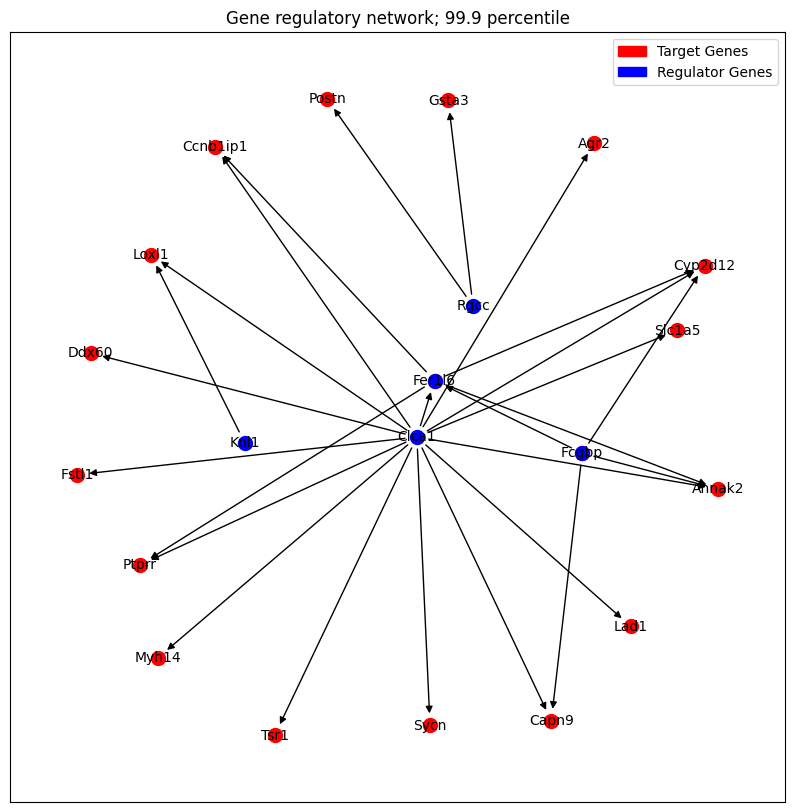

Regulator genes ranked by the number of connections:
1. Clca1: 15 connections
2. Fcgbp: 4 connections
3. Fer1l6: 4 connections
4. Rgcc: 2 connections
5. Knl1: 1 connections


In [ ]:
# Visualize Generated GRN for Mouse cells
gc_mat = pd.read_csv("gc_mat_mouse_interactions.tsv", sep='\t', index_col="Unnamed: 0")
visualize_network_top(gc_mat, percentile=99.5)
visualize_network_top(gc_mat, percentile=99.9)

negatives:  0


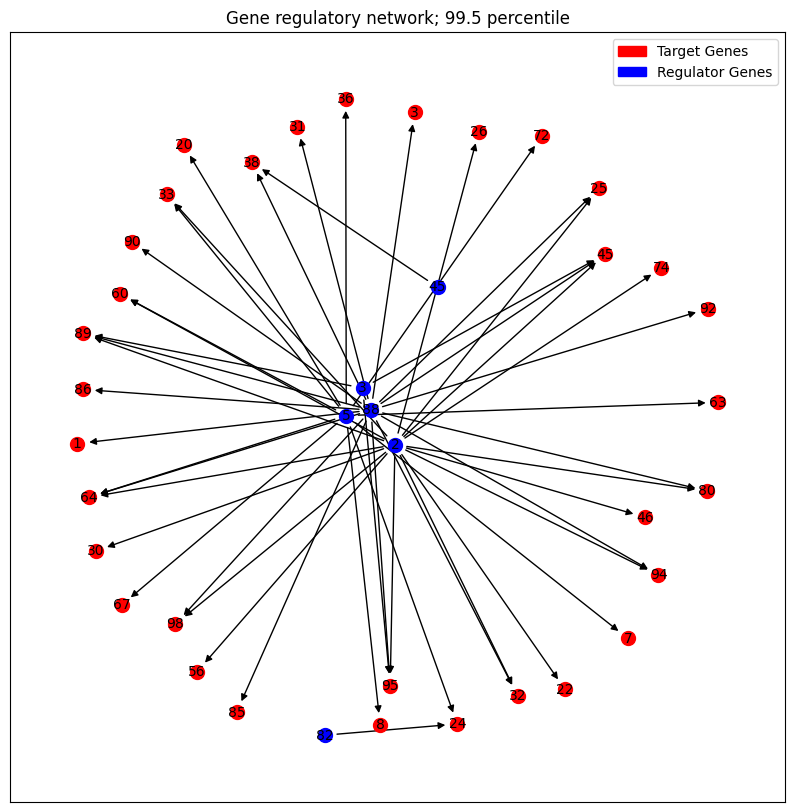

Regulator genes ranked by the number of connections:
1. 88: 17 connections
2. 2: 17 connections
3. 5: 11 connections
4. 3: 3 connections
5. 45: 1 connections
6. 82: 1 connections
negatives:  0


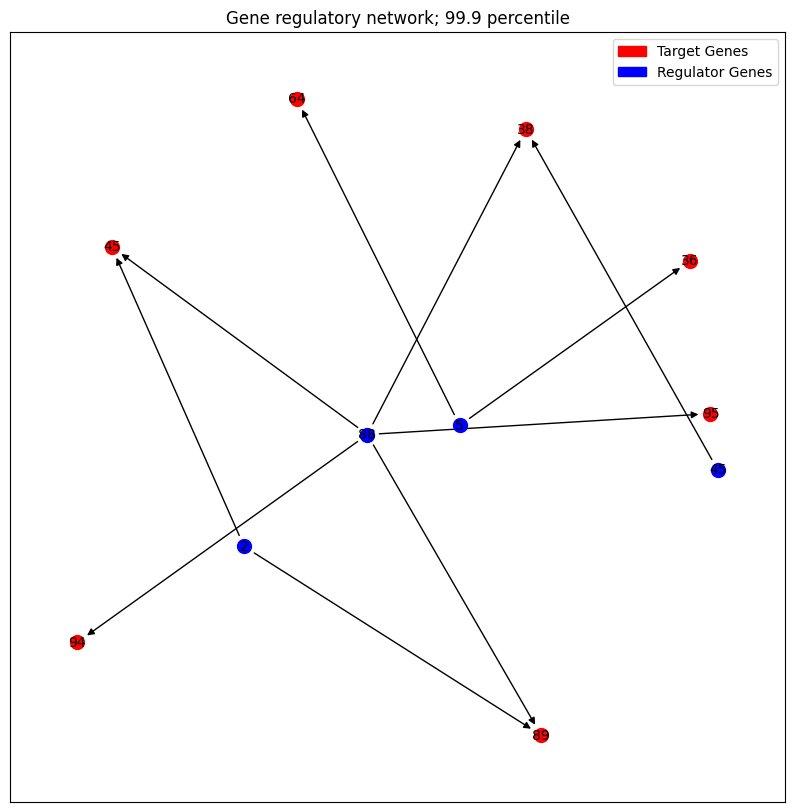

Regulator genes ranked by the number of connections:
1. 88: 5 connections
2. 2: 2 connections
3. 5: 2 connections
4. 45: 1 connections


In [ ]:
# Visualize Generated GRN for artificial dataset A
gc_mat_A = pd.read_csv("gc_mat_A_interactions.tsv", sep='\t', index_col="Unnamed: 0")
visualize_network_top(gc_mat_A, percentile=99.5)
visualize_network_top(gc_mat_A, percentile=99.9)

# After Velorama

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
os.chdir("drive/My Drive")

In [ ]:
os.listdir()

In [ ]:
adata=sc.read_h5ad('RNA velocity/adata.h5ad')
adata

In [ ]:
adata.uns['log1p']['base']=None

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='cell type', method='wilcoxon')

In [ ]:
adata.obs['cell type'].value_counts()

In [ ]:
##generate gene list specific for each cluster with log fold change >1.5
cell_type=['Stem cells','TA','TA2','EC2','GC2','EC','GC','EEc','Unknown']
df_cell_type={}
for cell in cell_type:
    df_cell_type[cell]=sc.get.rank_genes_groups_df(adata,log2fc_min=1.5,group=cell)

In [ ]:
df_cell_type['EC']

,names,scores,logfoldchanges,pvals,pvals_adj
0,Slc26a3,13.509066,6.392756,1.382648e-41,2.604217e-37
1,Prdx6,13.344456,5.032197,1.275997e-40,1.201670e-36
2,Prss30,12.951486,6.233897,2.304505e-38,1.446845e-34
3,Slc15a1,12.666658,5.784680,9.048794e-37,4.260851e-33
4,Selenop,12.605573,4.472602,1.967378e-36,7.411113e-33
...,...,...,...,...,...
2145,AC160336.1,-0.025571,2.334791,9.795999e-01,1.000000e+00
2146,Gm42700,-0.049721,1.734427,9.603451e-01,1.000000e+00
2147,Hoxa6,-0.071029,1.631577,9.433744e-01,1.000000e+00
2148,Gng3,-0.116311,1.552573,9.074065e-01,1.000000e+00


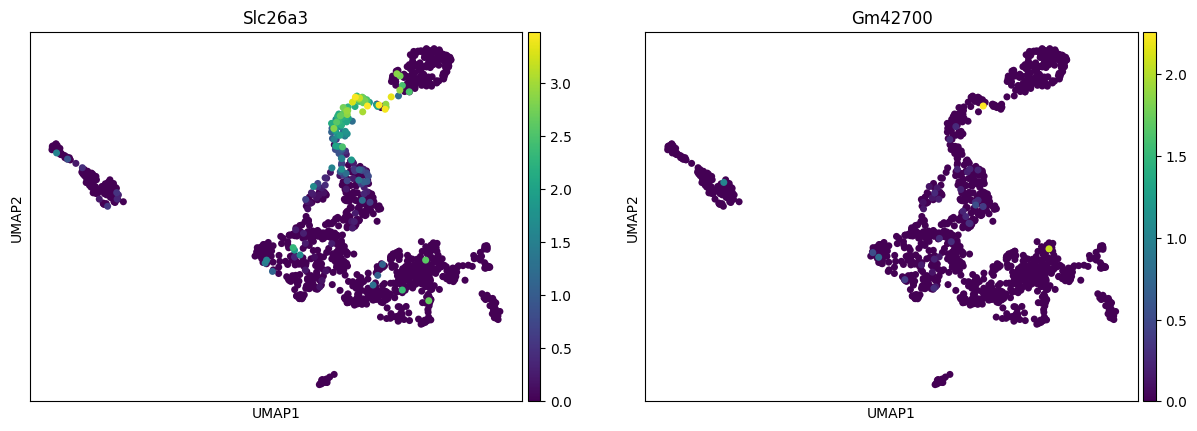

In [ ]:
sc.pl.umap(adata, color=['Slc26a3', 'Gm42700'])# this marker for EC, but we need to filter out low expressed gene (low score value)

In [ ]:
df_cell_type['EC2']

,names,scores,logfoldchanges,pvals,pvals_adj
0,Actb,18.553059,2.481602,7.704016e-77,1.451052e-72
1,Krt8,18.412100,2.678210,1.050694e-75,9.894909e-72
2,S100a10,17.955206,3.099963,4.369641e-72,2.743406e-68
3,Lgals3,17.848791,4.266211,2.953635e-71,1.390793e-67
4,S100a6,17.273041,2.633070,7.508075e-67,2.828292e-63
...,...,...,...,...,...
380,Gch1,-1.578747,1.824210,1.143941e-01,2.267297e-01
381,Gsta1,-1.638308,1.518646,1.013575e-01,2.033738e-01
382,Sult2b1,-1.730163,1.549913,8.360117e-02,1.701190e-01
383,Egfr,-1.994876,1.533531,4.605643e-02,9.735948e-02


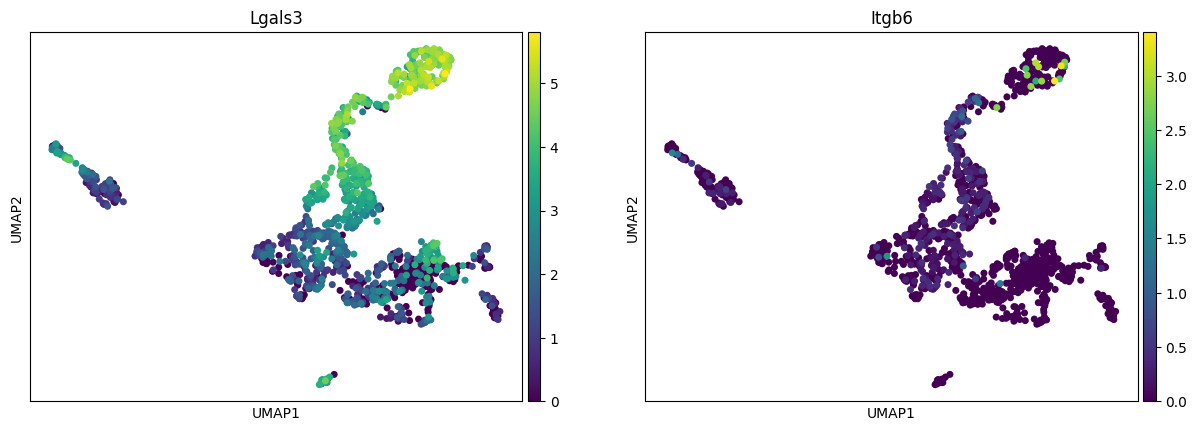

In [ ]:
sc.pl.umap(adata, color=['Lgals3', 'Itgb6'])# this marker for EC, but we need to filter out low expressed gene (low score value)

In [ ]:
##filter out gene list without scores value less than 10
df_cell_type_filter={}
for key in df_cell_type.keys():
  df_cell_type_filter[key]= df_cell_type[key][ df_cell_type[key].scores>10]

In [ ]:
df_cell_type_filter['EC']

,names,scores,logfoldchanges,pvals,pvals_adj
0,Slc26a3,13.509066,6.392756,1.382648e-41,2.604217e-37
1,Prdx6,13.344456,5.032197,1.275997e-40,1.201670e-36
2,Prss30,12.951486,6.233897,2.304505e-38,1.446845e-34
3,Slc15a1,12.666658,5.784680,9.048794e-37,4.260851e-33
4,Selenop,12.605573,4.472602,1.967378e-36,7.411113e-33
...,...,...,...,...,...
77,Cd2ap,10.103032,2.188096,5.355985e-24,7.820153e-22
78,St3gal4,10.093444,3.334276,5.906054e-24,8.556963e-22
79,Tm4sf20,10.068938,2.439917,7.579171e-24,1.089723e-21
80,Mgat4a,10.067518,2.507910,7.689417e-24,1.097198e-21


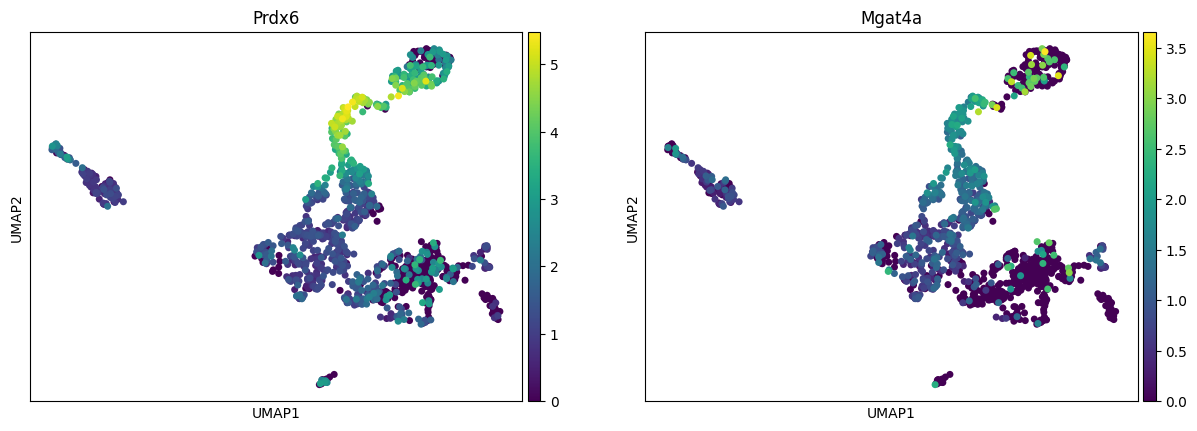

In [ ]:
sc.pl.umap(adata, color=['Prdx6', 'Mgat4a'])

In [ ]:
df_cell_type_filter##dictionary contain highly expressed gene specific for each cluster to use them as potential regulators for each cluster

{'Stem cells':    names     scores  logfoldchanges         pvals     pvals_adj
 0   Gpx2  16.635977        2.371879  3.824632e-62  3.601847e-58
 1   Ptma  16.578176        2.104151  1.002251e-61  6.292467e-58
 2  H2afz  12.027883        1.571496  2.535815e-33  1.182230e-31,
 'TA':              names     scores  logfoldchanges         pvals     pvals_adj
 0             Fut9  18.121059        3.742584  2.173698e-73  4.094161e-69
 1          Gm47283  17.115166        2.541304  1.143888e-65  1.077257e-61
 2           Sema5a  17.017017        2.624516  6.142087e-65  3.856207e-61
 3           Clca3b  16.480141        3.289589  5.096558e-61  2.399842e-57
 4            Kcnn4  16.398155        2.359584  1.971369e-60  7.426147e-57
 ..             ...        ...             ...           ...           ...
 490         Zfp131  10.025108        1.502078  1.182302e-23  1.801672e-22
 491         Dnajb4  10.023181        1.746277  1.205585e-23  1.832703e-22
 492  1700097N02Rik  10.023181        2.1362

In [ ]:
##we can also generate dataframe for differntially expressed genes in the whole dataset
##get genes with log fold change >=1.5
df_all= sc.get.rank_genes_groups_df(adata,log2fc_min=1.5,group=None)
print(df_all.head(3))
print(df_all.shape)

  group    names     scores  logfoldchanges         pvals     pvals_adj
0    EC  Slc26a3  13.509066        6.392756  1.382648e-41  2.604217e-37
1    EC    Prdx6  13.344456        5.032197  1.275997e-40  1.201670e-36
2    EC   Prss30  12.951486        6.233897  2.304505e-38  1.446845e-34
(16065, 6)


In [ ]:
##get the genes with scores more than 10
df_all_filter=df_all[df_all.scores>10]
###the list contain some mitochondrial genes (start with mt), we need to remove them
df_all_filter=df_all_filter[df_all_filter['names'].str.startswith('mt-')==False]
df_all_filter.shape###we can also use this list of genes as potenital regulator if we want to run Velorama on the whole dataset
df_all_filter.to_csv('RNA velocity/potenial_regulator.csv')

In [ ]:
###get the potenial drivers (target genes)
target_genes = pd.read_csv("RNA velocity/potenial driver.csv")
target_genes = target_genes.drop(['Unnamed: 0'], axis=1)
target_genes = np.unique(target_genes.to_numpy().flatten())

print(target_genes.shape)


(608,)


In [ ]:
np.array(df_all_filter.names)

array(['Slc26a3', 'Prdx6', 'Prss30', ..., 'Tnfrsf10b', 'Bcl3', 'Epb41l1'],
      dtype=object)

In [ ]:
regulator_genes = np.array(df_all_filter.names) # use highly expressed genes 
adata.var['is_reg'] = [n in regulator_genes for n in adata.var.index.values]
adata.var['is_target'] = [n in target_genes for n in adata.var.index.values]
adata.write('RNA velocity/adata.h5ad')

In [ ]:
## VELORAMA RNA_velocity RUN ON THIS DATA LOCALLY
## RESULTS IN gc_mat_mouse_interactions.tsv

# Pseudotime run of velorama

Diffusion map to order the cells according to the pesudeotime, the more the pesudotime, the more cells will be differentiated. Diffusion map also enable us to identify different branching points in our dataset


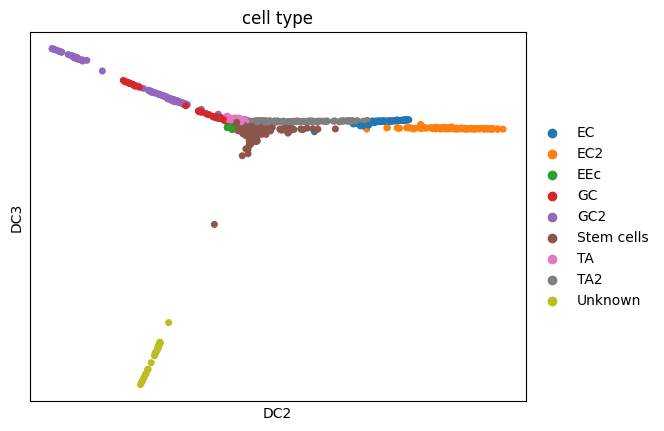

In [ ]:
##performing diffusion map
sc.tl.diffmap(adata)
sc.pl.diffmap(adata,color='cell type',components=['2,3'])

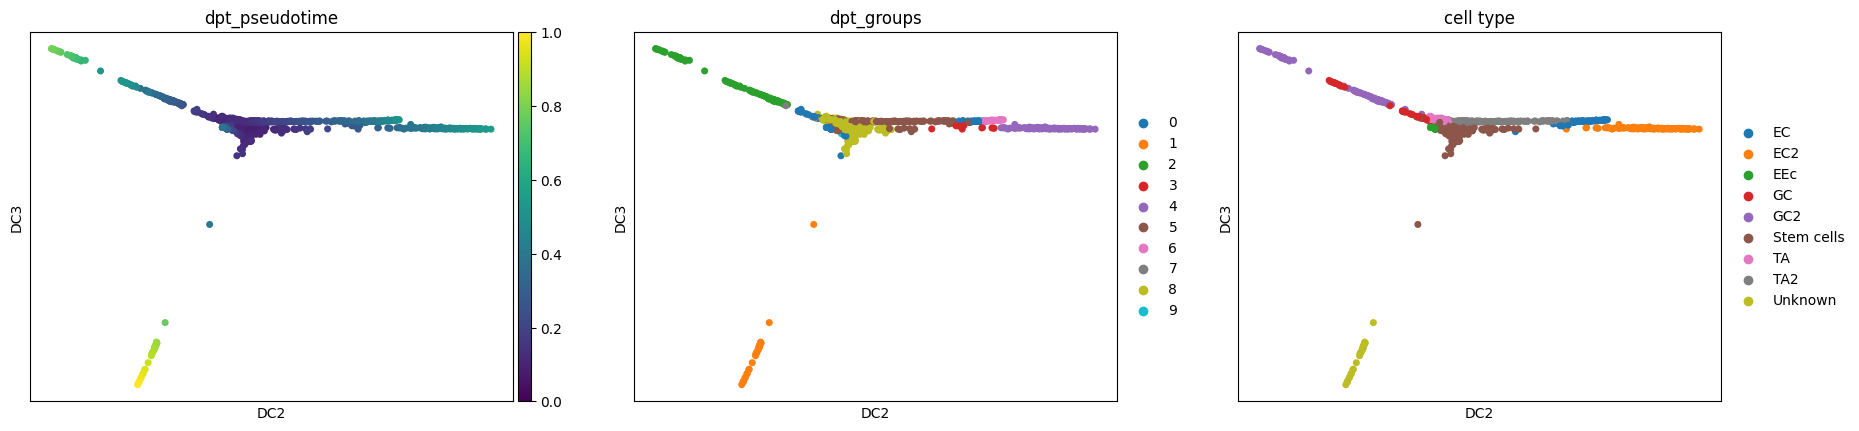

In [ ]:
##run diffusion psudotime(dpt)
##Identifying the root cell first  adata.uns['iroot']
adata.uns['iroot'] = np.flatnonzero(adata.obs['cell type'] == 'Stem cells')[0]
#run (dpt)
sc.tl.dpt(adata,n_branchings=3)##three branching (three lineages)
sc.pl.diffmap(adata, color=['dpt_pseudotime', 'dpt_groups', 'cell type'],components=['2,3'])


In [ ]:
adata.write('adata.h5ad')

Work on the simulated data (generate RNA velocity, diffusion map)

In [ ]:
dataset=['RNA velocity/dataset_A.h5ad','RNA velocity/dataset_B.h5ad','RNA velocity/dataset_C.h5ad']
data={x:sc.read_h5ad(x) for x in dataset}


In [ ]:
data['RNA velocity/dataset_A.h5ad']

AnnData object with n_obs × n_vars = 900 × 100
    obs: 'cell_type', 'time'
    var: 'is_reg', 'is_target'
    uns: 'iroot'
    layers: 'spliced', 'unspliced'

In [ ]:
for key in data.keys():
    sc.tl.pca(data[key], svd_solver='arpack')
    sc.pp.neighbors(data[key],n_neighbors=30,n_pcs=40)
    sc.tl.leiden(data[key])
    sc.tl.umap(data[key])
    sc.tl.diffmap(data[key])
    sc.tl.dpt(data[key])

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99885434 0.9960179  0.97093874 0.96978927 0.96330285
     0.9601411  0.95822895 0.9542518  0.94028366 0.92957145 0.9255609
     0.9217678  0.91865706 0.9070353 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing Diffusion Pseudotime us

In [ ]:
data['RNA velocity/dataset_A.h5ad']

AnnData object with n_obs × n_vars = 900 × 100
    obs: 'cell_type', 'time', 'leiden', 'dpt_pseudotime'
    var: 'is_reg', 'is_target'
    uns: 'iroot', 'pca', 'neighbors', 'leiden', 'umap', 'diffmap_evals'
    obsm: 'X_pca', 'X_umap', 'X_diffmap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

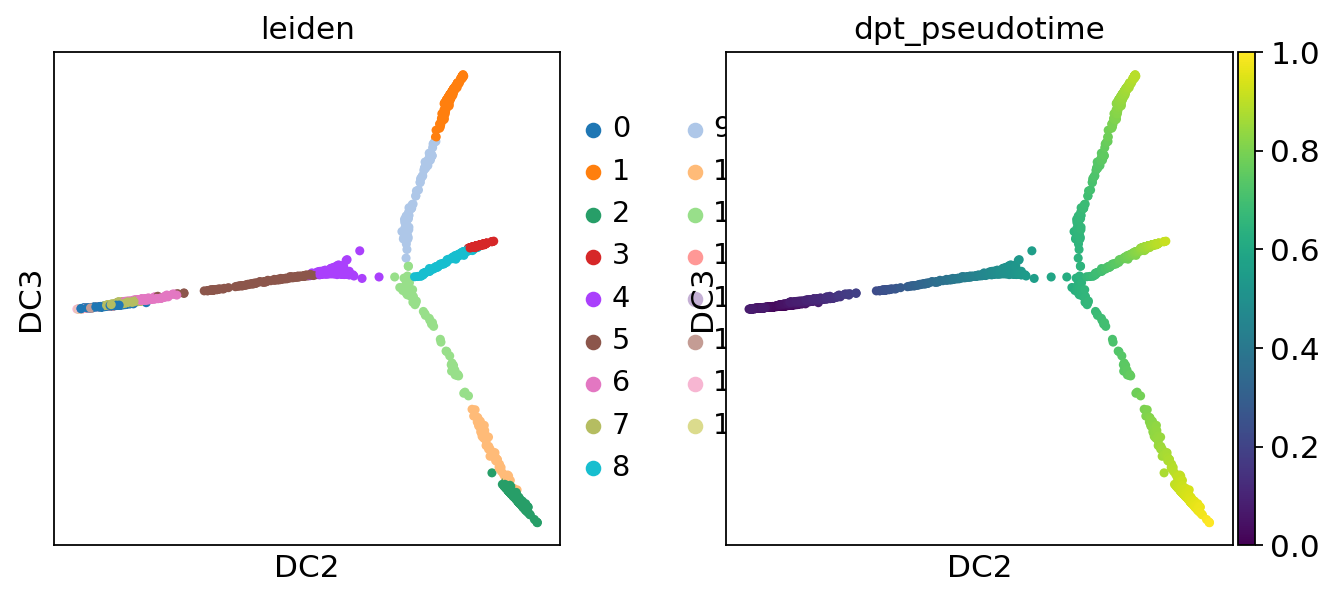

In [ ]:
sc.pl.diffmap(data['RNA velocity/dataset_C.h5ad'],color=['leiden','dpt_pseudotime'],components=['2,3'])

RUN RNA velocity to get the driver genes for each lineage

In [ ]:
for key in data.keys():
  scv.pp.filter_and_normalize(data[key], min_shared_counts=20, n_top_genes=5000)
  scv.pp.moments(data[key], n_pcs=30, n_neighbors=30)
  scv.tl.recover_dynamics(data[key])
  scv.tl.velocity(data[key], mode='dynamical')
  scv.tl.velocity_graph(data[key])
  scv.tl.rank_dynamical_genes(data[key], groupby='leiden')
  

Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/2 cores)


  0%|          | 0/100 [00:00<?, ?gene/s]

    finished (0:00:26) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/2 cores)


  0%|          | 0/900 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
ranking genes by cluster-specific likelihoods
    finished (0:00:00) --> added 
    'rank_dynamical_genes', sorted scores by group ids (adata.uns)
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/2 cores)


  0%|          | 0/100 [00:00<?, ?gene/s]

    finished (0:00:25) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/2 cores)


  0%|          | 0/1200 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
ranking genes by cluster-specific likelihoods
    finished (0:00:00) --> added 
    'rank_dynamical_genes', sorted scores by group ids (adata.uns)
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/2 cores)


  0%|          | 0/100 [00:00<?, ?gene/s]

    finished (0:00:33) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/2 cores)


  0%|          | 0/1800 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
ranking genes by cluster-specific likelihoods
    finished (0:00:00) --> added 
    'rank_dynamical_genes', sorted scores by group ids (adata.uns)


In [ ]:

for key in data.keys():
  data[key].write(f'{key}.h5ad')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


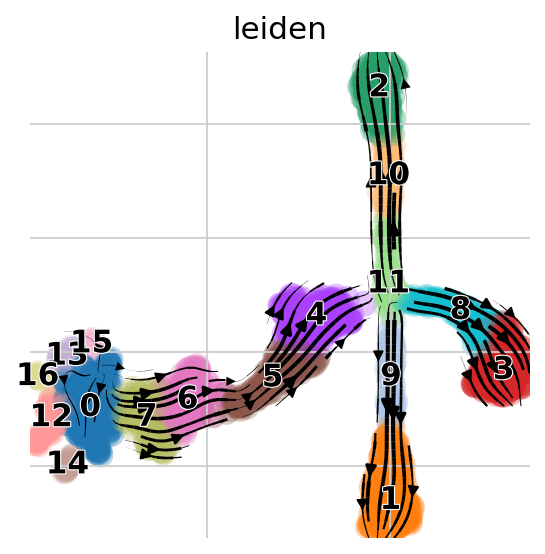

In [ ]:
scv.pl.velocity_embedding_stream(data['RNA velocity/dataset_C.h5ad'], basis='umap',color='leiden')

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


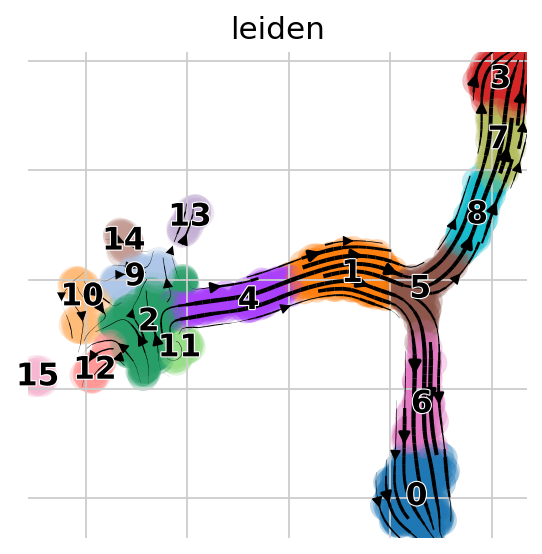

In [ ]:
scv.pl.velocity_embedding_stream(data['RNA velocity/dataset_B.h5ad'], basis='umap',color='leiden')

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


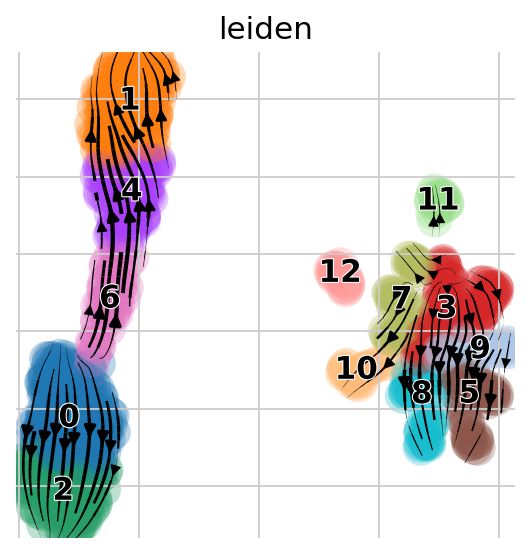

In [ ]:
scv.pl.velocity_embedding_stream(data['RNA velocity/dataset_A.h5ad'], basis='umap',color='leiden')

Rerun velorama on psudotime

In [ ]:
!velorama -ds adata -dyn pseudotime -dev cpu -l 3 -hd 32 -rd adata_for_velorama

Normalizing data: 0 mean, 1 SD
# of Regs: 313, # of Targets: 608
Constructing DAG...
2023-04-26 04:56:23.203204: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-26 04:56:32,569	INFO worker.py:1625 -- Started a local Ray instance.
Traceback (most recent call last):
  File "/usr/local/bin/velorama", line 5, in <module>
    velorama.execute_cmdline()
  File "/usr/local/lib/python3.9/dist-packages/velorama/run.py", line 127, in execute_cmdline
    analysis = tune.run(train_model,resources_per_trial=resources_per_trial,config=config,
  File "/usr/local/lib/python3.9/dist-packages/ray/tune/tune.py", line 668, in run
    config = inject_placeholders(
  File "/usr/local/lib/python3.9/dist-packages/ray/tune/impl/placeholder.py", line 136, in inject_placeholders
    return {
  File "/usr/local/lib/python3.9/dist-packages/ray/tune/impl/placeholder.py", line 137, in <dictcomp>
    k: inject_placeholders(v, resolvers, id_prefix + (k,), path_pr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("drive/My Drive")

In [ ]:
os.listdir()

['DATA',
 'VINP',
 'Discussion table.gsheet',
 'Exit Ticket.gform',
 'Assessment.gform',
 'Student Invited Speaker.gsheet',
 'ATAC-seq project',
 'ScRNA-seq',
 'Colab Notebooks',
 'potenial_regulator.csv',
 'RNA velocity',
 'adata_for_velorama',
 'Using RNA velocity to construct GRN.gslides',
 'Copy of gc_mat_A_lags.tsv']

In [ ]:
os.path.dirname('/RNA velocity') 

'/'

In [ ]:
os.listdir()

['DATA',
 'VINP',
 'Discussion table.gsheet',
 'Exit Ticket.gform',
 'Assessment.gform',
 'Student Invited Speaker.gsheet',
 'ATAC-seq project',
 'ScRNA-seq',
 'Colab Notebooks',
 'potenial_regulator.csv',
 'RNA velocity',
 'adata_for_velorama',
 'Using RNA velocity to construct GRN.gslides']

In [ ]:
pwd


'/content/drive/My Drive'

In [ ]:
cd RNA velocity

/content/drive/My Drive/RNA velocity


In [ ]:
ls

 adata_for_velorama/            gc_mat_B_interactions.tsv
 adata.h5ad                     gc_mat_B_lags.tsv
 barcodes.tsv                   gc_mat_C_interactions.tsv
 dataset_A.h5ad                 gc_mat_C_lags.tsv
 dataset_A.h5ad.h5ad            gc_mat_D_interactions.tsv
 dataset_B.h5ad                 gc_mat_D_lags.tsv
 dataset_B.h5ad.h5ad            gc_mat_mouse_interactions.tsv
 dataset_C.h5ad                 matrix.mtx
 dataset_C.h5ad.h5ad            MOCK.loom
 dataset_D.h5ad                'potenial driver.csv'
 features.tsv                   potenial_regulator.csv
 gc_mat_A_interactions.gsheet   potenial_regulator.gsheet
 gc_mat_A_interactions.tsv      tozipandsend.zip
 gc_mat_A_lags.tsv


# AUPRC

AUPRC, was calculated by considering y_true the all target genes (row/index) 

In [ ]:
##read files
A_data=pd.read_csv('gc_mat_A_interactions.tsv',sep='\t')
B_data=pd.read_csv('gc_mat_B_interactions.tsv',sep='\t')
C_data=pd.read_csv('gc_mat_C_interactions.tsv',sep='\t')
D_data=pd.read_csv('gc_mat_D_interactions.tsv',sep='\t')

mouse_data=pd.read_csv('gc_mat_mouse_interactions.tsv',sep='\t')

In [ ]:
mouse_data.head(3)
mouse_data

,Unnamed: 0,Gsta3,Dst,Neurl3,Cnnm4,Tmem131,Mgat4a,Slc9a2,Slc40a1,Myo1b,...,Hells,Cyp2c68,Sema4g,Slc6a14,Il13ra1,Slc6a8,L1cam,Gk,Kif4,Nox1
0,Gsta3,0.000706,0.001672,0.000951,0.000626,0.0,0.000082,0.000438,0.000081,0.000784,...,0.003400,0.001028,0.002533,0.001266,0.000289,0.000056,0.000635,0.0,0.003970,0.003178
1,Mgat4a,0.000476,0.002746,0.000600,0.000445,0.0,0.000058,0.001097,0.000046,0.000575,...,0.001792,0.000733,0.003965,0.001310,0.000443,0.000081,0.001481,0.0,0.001866,0.001955
2,Sgo2a,0.000610,0.000771,0.000551,0.000841,0.0,0.000057,0.001192,0.000033,0.000290,...,0.001531,0.000701,0.001830,0.000458,0.000513,0.000084,0.000498,0.0,0.002916,0.001718
3,Ptprn,0.000313,0.000354,0.000135,0.000089,0.0,0.000018,0.000269,0.000026,0.000137,...,0.000358,0.000310,0.000483,0.000214,0.000153,0.000024,0.000257,0.0,0.000733,0.000457
4,Tnni1,0.000591,0.002189,0.000586,0.000759,0.0,0.000093,0.000988,0.000106,0.000531,...,0.001207,0.001323,0.002281,0.000993,0.000618,0.000108,0.000697,0.0,0.002814,0.003312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,Cep55,0.000396,0.000922,0.000554,0.000504,0.0,0.000063,0.000578,0.000060,0.000202,...,0.003391,0.000638,0.001600,0.000412,0.000631,0.000112,0.000845,0.0,0.005443,0.002780
78,Hells,0.000459,0.000969,0.000517,0.000547,0.0,0.000061,0.000553,0.000040,0.000243,...,0.000906,0.000319,0.002138,0.000435,0.000372,0.000068,0.000914,0.0,0.002614,0.002538
79,Cyp2c68,0.000549,0.001389,0.000321,0.000614,0.0,0.000089,0.001382,0.000127,0.000254,...,0.002983,0.000399,0.002165,0.001174,0.000221,0.000045,0.000644,0.0,0.002869,0.003430
80,Kif4,0.000533,0.001039,0.000606,0.000247,0.0,0.000097,0.000750,0.000048,0.000192,...,0.001985,0.000593,0.001863,0.000467,0.000324,0.000105,0.000864,0.0,0.000996,0.001327


In [ ]:
mouse_data=mouse_data.set_index('Unnamed: 0')

A_data=A_data.set_index('Unnamed: 0')
B_data=B_data.set_index('Unnamed: 0')
C_data=C_data.set_index('Unnamed: 0')
D_data=D_data.set_index('Unnamed: 0')

In [ ]:
mouse_data.head(3)

,Gsta3,Dst,Neurl3,Cnnm4,Tmem131,Mgat4a,Slc9a2,Slc40a1,Myo1b,Mfsd6,...,Hells,Cyp2c68,Sema4g,Slc6a14,Il13ra1,Slc6a8,L1cam,Gk,Kif4,Nox1
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
Gsta3,0.000706,0.001672,0.000951,0.000626,0.0,0.000082,0.000438,0.000081,0.000784,0.001286,...,0.003400,0.001028,0.002533,0.001266,0.000289,0.000056,0.000635,0.0,0.003970,0.003178
Mgat4a,0.000476,0.002746,0.000600,0.000445,0.0,0.000058,0.001097,0.000046,0.000575,0.001102,...,0.001792,0.000733,0.003965,0.001310,0.000443,0.000081,0.001481,0.0,0.001866,0.001955
Sgo2a,0.000610,0.000771,0.000551,0.000841,0.0,0.000057,0.001192,0.000033,0.000290,0.000539,...,0.001531,0.000701,0.001830,0.000458,0.000513,0.000084,0.000498,0.0,0.002916,0.001718


In [ ]:
##get the top 5% and the rest is converted to nan
df_mouse=mouse_data.where(mouse_data>=np.percentile(mouse_data.to_numpy().flatten(),95),np.nan)
df_A=A_data.where(A_data>=np.percentile(A_data.to_numpy().flatten(),95),np.nan)
df_B=B_data.where(B_data>=np.percentile(B_data.to_numpy().flatten(),95),np.nan)
df_C=C_data.where(C_data>=np.percentile(C_data.to_numpy().flatten(),95),np.nan)
df_D=D_data.where(D_data>=np.percentile(D_data.to_numpy().flatten(),95),np.nan)

In [ ]:
##remove row if all of the row has NA 
df_mouse=df_mouse.dropna(how = 'all')

df_A=df_A.dropna(how='all')
df_B=df_B.dropna(how='all')
df_C=df_C.dropna(how='all')
df_D=df_D.dropna(how='all')




In [ ]:
df_D.head(5)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.003167,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003169,...,NaN,NaN,NaN,NaN,0.003469,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def get_Ys(Y1,Y2):
    #Y1 is the target genes stored in adata.var  as all genes should interacts with their candidate regulators 
    #Y2 is target genes with top 5% interaction with at least one candidate regulator
    true=[]
    pred=[]
    
    for i in Y1.index.values:###has the target genes (all of them)
        if i in Y2.index.values:##has the top 5% target genes
            true.append(1)
        else:
            true.append(0)
    
    for i in Y2.index.values:
        if i in Y1.index.values:
            pred.append(1)
        else:
            pred.append(0)
            
    index=-1
    for i in true:
        index+=1
        if i not in pred:
            pred.insert(index,2)
        
        
    return np.array(true), np.array(pred)

In [ ]:
A=get_Ys(A_data,df_A)
B=get_Ys(B_data,df_B)
C=get_Ys(C_data,df_C)
D=get_Ys(D_data,df_D)

mouse=get_Ys(mouse_data,df_mouse)

In [ ]:
##calculating AUCPR
from sklearn.metrics import average_precision_score
PR_A=average_precision_score(A[0],A[1])
PR_B=average_precision_score(B[0],B[1])
PR_C=average_precision_score(C[0],C[1])
PR_D=average_precision_score(D[0],D[1])

PR_mouse=average_precision_score(mouse[0],mouse[1])

In [ ]:
print('AUPRC for dataset_A :', PR_A)
print('AUPRC for dataset_B :', PR_B)
print('AUPRC for dataset_C :', PR_C)
print('AUPRC for dataset_D :', PR_D)

print('AUPRC for mouse :', PR_mouse)##this one I considered y_true to be the genes that show interaction with candidate regulator regardless the strenght of interaction

AUPRC for dataset_A : 0.92
AUPRC for dataset_B : 0.96
AUPRC for dataset_C : 0.98
AUPRC for dataset_D : 0.95
AUPRC for mouse : 0.9146341463414634


Recalculating AUPRC using target genes stored in adata.var. I am considering all genes in adata.var[is_target] is the y_true...

In [ ]:
import scanpy as sc

In [ ]:
mouse_adata=sc.read_h5ad('adata.h5ad')

In [ ]:
mouse_target=mouse_adata.var['is_target'][mouse_adata.var['is_target']==True]

In [ ]:
mouse_target

Tmem70        True
Paqr8         True
Gsta3         True
Dst           True
Neurl3        True
              ... 
Pola1         True
Kif4          True
Nox1          True
Alas2         True
AC149090.1    True
Name: is_target, Length: 608, dtype: bool

In [ ]:
mouse_data=get_Ys(mouse_target,df_mouse)

In [ ]:
PR_mouse_data=average_precision_score(mouse_data[0],mouse_data[1])

In [ ]:
print('AUPRC for dataset_A :', PR_A)
print('AUPRC for dataset_B :', PR_B)
print('AUPRC for dataset_C :', PR_C)
print('AUPRC for dataset_D :', PR_D)

print('AUPRC for mouse :', PR_mouse_data)##this result does make sense to me

AUPRC for dataset_A : 0.92
AUPRC for dataset_B : 0.96
AUPRC for dataset_C : 0.98
AUPRC for dataset_D : 0.95
AUPRC for mouse : 0.12335526315789473
